In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image,ImageOps 
import os
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from sklearn import model_selection
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import gc
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available devices
print("Available devices:", tf.config.list_physical_devices())

2024-11-19 07:24:12.446298: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 07:24:12.493793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 07:24:12.493821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 07:24:12.495124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 07:24:12.502754: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-11-19 07:24:15.195130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:24:15.245609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:24:15.248946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Check the mode of image
sample_image_directory = '../Datasets/mrlEyes/s0001/s0001_00001_0_0_0_0_0_01.png'
image = image = Image.open(sample_image_directory)
print("Image mode: ",image.mode)

# All the images are in grayscale mode (i.e L 8-bit grayscale)

Image mode:  L


In [3]:
# Initialize lists to store image data and labels
img_path_list = []
label = []

# Define the path to the directory containing the images
directory = '../Datasets/mrlEyes'

# Loop through each subdirectory and process images
for i in tqdm(os.listdir(directory), desc="Processing directories"):
    # Construct the full path to each subdirectory in 'directory'
    sub_path = os.path.join(directory, i)
    if os.path.isdir(sub_path):
        # Use tqdm for tracking progress within each subdirectory
        for j in tqdm(os.listdir(sub_path), desc=f"Processing images in {i}", leave=False):
            img_path = os.path.join(sub_path, j)
            img_path_list.append(img_path)

            # Assign labels based on filename convention
            if len(j) > 16 and j[16] == '1':  # Ensure index 16 exists in filename
                label.append(1)  # Drowsy
            else:
                label.append(0)  # Non-Drowsy

label = np.array(label)

print("Label shape:", label.shape)


Processing directories: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]

Label shape: (84898,)


In [4]:
# Split into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(img_path_list, label, test_size=0.3, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

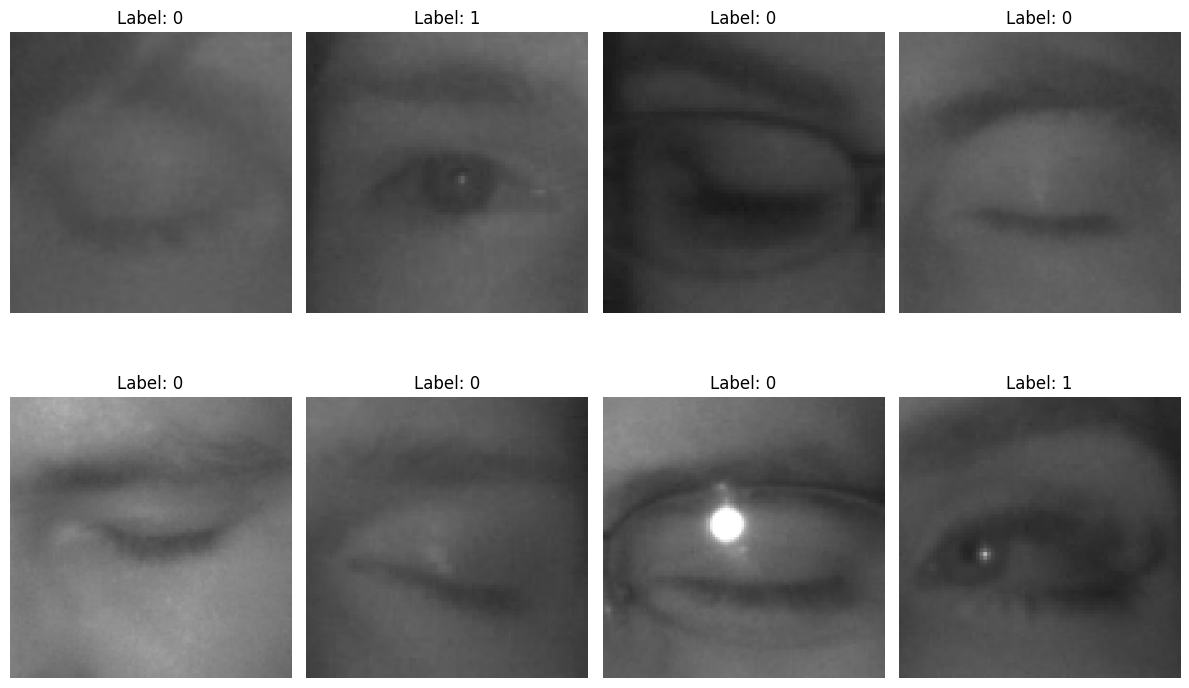

In [6]:
# Visualize original images (before augmentation)
batch_paths, batch_labels = train_paths[:8], train_labels[:8]  # Use first 8 images for visualization

plt.figure(figsize=(12, 8))
for i, img_path in enumerate(batch_paths):
    # Load and preprocess the image
    original_image = load_img(img_path, target_size=(224, 224), color_mode='rgb')  # Load image
    original_image = img_to_array(original_image) / 255.0  # Normalize pixel values

    # Plot the original image
    plt.subplot(2, 4, i + 1)  # Arrange images in a 2x4 grid
    plt.imshow(original_image)
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
# Define an augmentation generator
augmentation_generator = ImageDataGenerator(
        rotation_range=90,          # Slight rotations
        horizontal_flip=True,       # Flip horizontally
        zoom_range=0.5,             # Slight zoom in/out
        width_shift_range=0.1,      # Horizontal shifts
        height_shift_range=0.1,     # Vertical shifts
        shear_range=10,             # Shearing distortions
        fill_mode='nearest'         # Fill missing pixels
)

In [8]:
# Define a custom DataGenerator class
class MRLDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, target_size=(224, 224),shuffle = True, augment = False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        # Fetch batch data
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        for file_path in batch_paths:
            # Load and preprocess the image
            image = load_img(file_path, target_size=self.target_size, color_mode='rgb')
            image = img_to_array(image) / 255.0  # Normalize to [0, 1]
            if self.augment:
                image = augmentation_generator.random_transform(image)
            images.append(image)
        
        return np.array(images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Batch size
batch_size = 32

# Create generators
train_generator = MRLDataGenerator(train_paths, train_labels, batch_size=batch_size, augment = True)
val_generator = MRLDataGenerator(val_paths, val_labels, batch_size=batch_size)
test_generator = MRLDataGenerator(test_paths, test_labels, batch_size=batch_size)


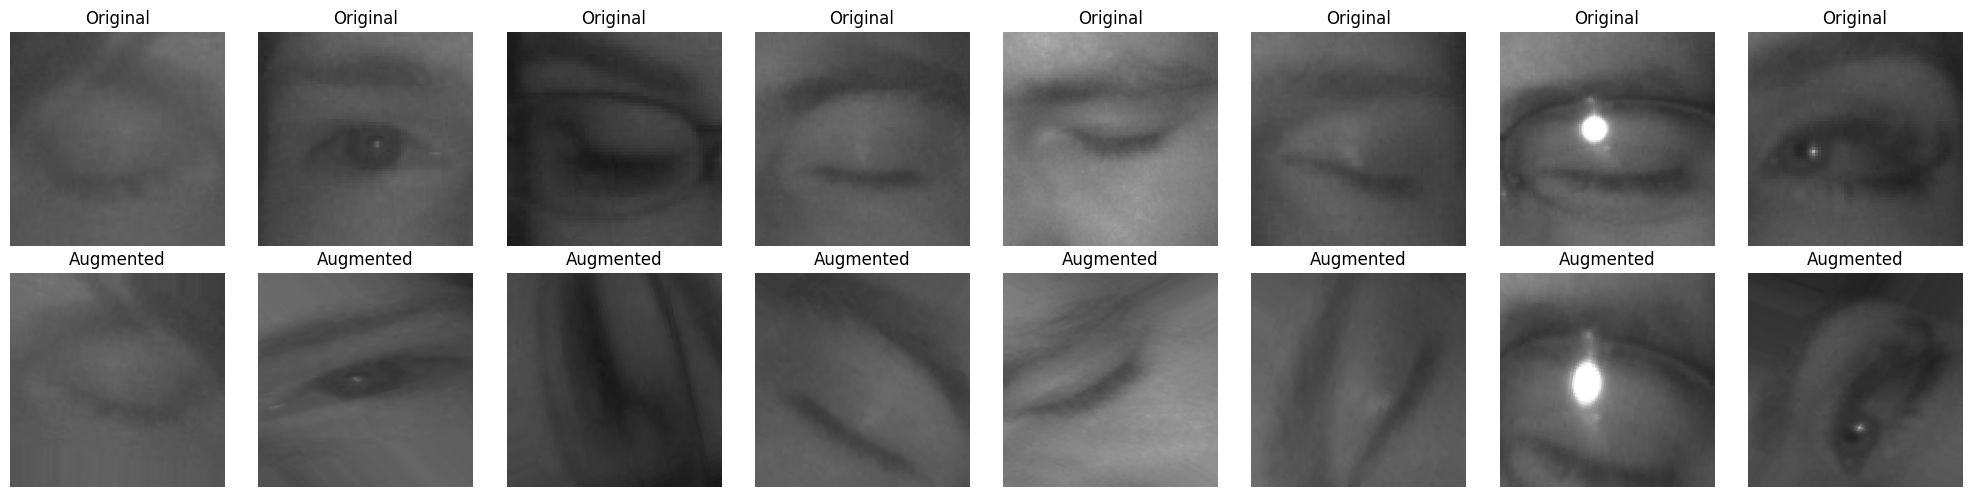

In [12]:
original_images = []
for i in range(8):  # Load first 8 images
    img_path = train_paths[i]
    original_image = load_img(img_path, target_size=(224, 224), color_mode='rgb')
    original_images.append(img_to_array(original_image) / 255.0)  # Normalize

# Get augmented images from the generator
batch_images, batch_labels = train_generator[0]  # First batch with augment=True

# Plot comparison of original and augmented images horizontally
plt.figure(figsize=(20, 5))  # Adjust figure size for horizontal layout

for i in range(8):
    # Plot original image
    plt.subplot(2, 8, i + 1)  # 2 rows, 8 columns (row 1: original)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(2, 8, i + 9)  # 2 rows, 8 columns (row 2: augmented)
    plt.imshow(batch_images[i])
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout(pad=1.0)  # Reduce gaps between plots
plt.show()


In [13]:
# Load MobileNetV2 for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model
# base_model.summary()

2024-11-19 07:30:13.618059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:30:13.622815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:30:13.625874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/10


2024-11-18 14:26:35.242527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-11-18 14:26:59.301411: I external/local_xla/xla/service/service.cc:168] XLA service 0x799a50891ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 14:26:59.301444: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-18 14:26:59.307960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731940019.408557    6409 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1858/1858 [==============================] - 137s 59ms/step - loss: 0.1629 - accuracy: 0.9378 - val_loss: 0.1114 - val_accuracy: 0.9586
Epoch 2/10
 585/1858 [========>.....................] - ETA: 48s - loss: 0.1222 - accuracy: 0.9551

KeyboardInterrupt: 

In [9]:
model.save('../content/model2.h5', overwrite=True)